In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
import sympy

from pyiga import bspline, assemble, vform, geometry, vis, solvers, ieti, topology

#import importlib
#importlib.reload(pyiga.assemble)

In [3]:
# define discretization space (the same in each patch)
p = 3
kvs = 2 * (bspline.make_knots(p, 0.0, 1.0, 3),) # 15

Basis setup took 0.003729581832885742 seconds


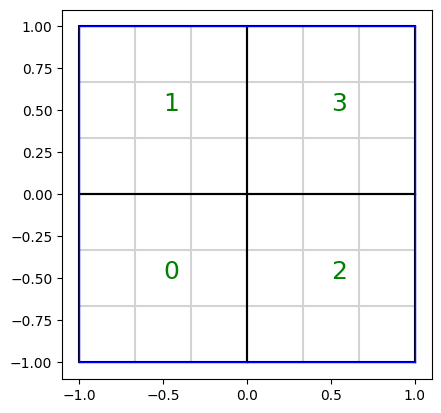

In [4]:
# define geometry
geos = [
    geometry.unit_square().translate((-1, -1)),
    geometry.unit_square().translate((-1, 0)),
    geometry.unit_square().translate((0, -1)),
    geometry.unit_square().translate((0, 0)),
]

patches = [(kvs, g) for g in geos]

# set up a PatchMesh object, which detects interfaces between patches
M = topology.PatchMesh(patches)
#bnd = M.outer_boundaries
#print(bnd)

# by default all outer boundaries are given the index 0, which we will use for the Dirichlet boundary
# let us generate a Neumann boundary indexed by 1
#M.set_boundary_id({0:{(0,0),(0,1),(1,0),(3,3)}})

# visualize the PatchMesh object with Dirichlet boundary (blue) and Neumann boundary (red)
M.draw(patch_idx = True, knots=True, bcolor={0:'blue',1:'red'})

# set up a MultiPatch object that initializes a Basis to map global dofs to local dofs
MP = assemble.Multipatch(M, automatch=True)
#MP.finalize()

# Constraint matrices for ieti-dp for each patch
cpp = MP.get_crosspoints()
#print(cpp)
#B = MP.Constr1 

In [42]:
### Define data and prepare Dirichlet boundary dofs

# source term f and Dirichlet boundary function g
f = lambda x, y: 1
gN = lambda x,y: 0 

# set up Dirichlet boundary conditions
bcs = MP.compute_dirichlet_bcs({0:gN})
globbnd = np.zeros((MP.Basis.shape[1],))
globbnd[bcs[0]] = 1
patchwisebcs = MP.Basis@globbnd
localbndindex = np.where(patchwisebcs - 1 > -1e-12)[0]
bndvalues = np.zeros((1,len(localbndindex)))[0]
bcs = tuple((localbndindex, bndvalues))

# Helper dictionary 
params = {'f' : f, 'g' : gN}

In [338]:
### Linear system assembly and restrictions

# assemble the lhs of the linear system
Ak = [assemble.assemble('tr(hess(u)) * tr(hess(v)) * dx', kvs, bfuns=[('u',1), ('v',1)], geo=g) for g in geos]
#Ak = [assemble.assemble('inner(grad(grad(u)), grad(grad(v))) * dx', kvs, bfuns=[('u',1), ('v',1)], geo=g) for g in geos]
A = scipy.sparse.block_diag(Ak, format='csr')

print(print("Rank ", np.linalg.matrix_rank(A.A), " vs. shape ", A.shape))


# Assemble the rhs of the linear system 
rhs = [assemble.assemble('f * v * dx', kvs, params, bfuns=[('v',1)], geo=g).ravel() for g in geos]
# generate Neumann vector for global contribution to the right hand side, in this case it is a zero vector since g1 is zero
N = MP.Basis@MP.assemble_surface('g1 * inner(grad(v),n) * ds', arity=1, g1=gN, boundary_idx=0)
rhs = np.hstack(rhs) + N

# Eliminate Dirichlet dofs
BCRestr = assemble.RestrictedLinearSystem(A, rhs, bcs)
free_dofs = LS.R_free

# Eliminate the Dirichlet dofs from the interface dofs
nnz_per_col = MP.Constr.getnnz(axis=0)
intf_dofs = np.where(nnz_per_col > 0)[0]
intfs = np.setdiff1d(intf_dofs, bcs[0])

# Patchwise restrictions
"""
Akii = []
Akbb = []
Akbi = []
bnd_dofs = np.concatenate([indices for indices in assemble.boundary_dofs(kvs)])
for p in range(len(MP.mesh.patches)):
    I = scipy.sparse.eye(Ak[p].shape[1], format='csr')
    mask = np.zeros(Ak[p].shape[1], dtype=bool)

    intindices = (intfs < MP.N_ofs[p+1]) & (intfs >= MP.N_ofs[p])
    intindices = intfs[intindices]-MP.N_ofs[p]
    
    mask[intindices] = True
    Rbb = I[mask]
    Akbb.append(Rbb.dot(Ak[p]).dot(Rbb.T)) 
    
    mask = np.ones(Ak[p].shape[1], dtype=bool)
    mask[bnd_dofs] = False
    Rii = I[mask]
    Akii.append(Rii.dot(Ak[p]).dot(Rii.T)) 
    
    Akbi.append(Rbb.dot(Ak[p]).dot(Rii.T))
""" 

# Compute the partial matrices 
I = scipy.sparse.eye(A.shape[1], format='csr')
mask = np.zeros(A.shape[1], dtype=bool)
mask[list(intfs)] = True
Rbb = I[mask]
mask = np.ones(A.shape[1], dtype=bool)
bnd_dofs = np.concatenate([indices for indices in assemble.boundary_dofs(kvs)])

for p in range(len(patches)):
    mask[bnd_dofs+MP.N_ofs[p]] = False

Rii = I[mask]

Abb = Rbb.dot(A).dot(Rbb.T)
Aii = Rii.dot(A).dot(Rii.T)
Abi = Rbb.dot(A).dot(Rii.T)
Aib = Abi.T
#print(Abi.shape)

# The matrices and vectors without the Dirichlet dofs
A = BCRestr.A
rhs = BCRestr.b

print(print("Rank ", np.linalg.matrix_rank(A.A), " vs. shape ", A.shape))

assert A.shape[1] == rhs.shape[0], "Size of rhs is different to size of the matrix"

# Other method for assembly
#def bilinear():
#    vf = vform.VForm(2)
#   u, v = vf.basisfuns()
#    vf.add(vform.tr(vform.hess(u)) * vform.tr(vform.hess(v)) * vform.dx)
#    return vf

#a = bilinear()

Rank  112  vs. shape  (144, 144)
None
Rank  92  vs. shape  (100, 100)
None


In [339]:
### Construct the constraint matrix C that immediately eliminates the columns related to Dirichlet conditions
def construct_constraint_matrices():
    eliminate_constraints = np.array([], dtype=int)
    Ck = []
    loc_dirichlet = []
    for p in range(len(MP.mesh.patches)):
        bndindices = (bcs[0] < MP.N_ofs[p+1]) & (bcs[0] >= MP.N_ofs[p])
        to_eliminate = bcs[0][bndindices]-MP.N_ofs[p]
        
        loc, glob = cpp[p][0]
        
        nnz_per_row = MP.Constr1[:,loc+MP.N_ofs[p]].getnnz(axis=1)
        result = np.where(nnz_per_row > 0)[0]
        eliminate_constraints = np.union1d(eliminate_constraints, result)
        
        ck = MP.Constr1[result,MP.N_ofs[p]:MP.N_ofs[p+1]]
        ck = np.delete(ck.A, 
                       to_eliminate, 
                       axis=1)
                
        q,r = np.linalg.qr(ck.T)
        ck = scipy.sparse.csr_matrix(ck[np.abs(np.diag(r))>=1e-10])
        
        #if p == 3:
        #    print("Ck", result)
        
        Ck.append(ck)
        loc_dirichlet.append(to_eliminate)

    return Ck, scipy.sparse.block_diag(Ck), eliminate_constraints, loc_dirichlet

In [340]:
Ck, C, eliminate_rows, loc_dirichlet = construct_constraint_matrices()
print(eliminate_rows)

[ 5 11 12 18 24 30 41 47]


In [341]:
def construct_primal_basis(Ak, Ck):
    Psi = []
    for p in range(len(patches)):
        a = Ak[p*Ck[p].shape[1]:(p+1)*Ck[p].shape[1], p*Ck[p].shape[1]:(p+1)*Ck[p].shape[1]]
        c = Ck[p]
        AC = scipy.sparse.bmat(
        [[a, c.T],
         [c,  None   ]], format='csr')
        RHS = np.vstack([np.zeros((a.shape[0],c.shape[0])), np.identity(c.shape[0])])
        psi = scipy.sparse.linalg.spsolve(AC, RHS)
        psi, delta = psi[:a.shape[0],], psi[a.shape[0]:,]
        
        Psi.append(psi)
        
    return Psi

In [342]:
Psik=construct_primal_basis(A, Ck)

PSI = scipy.sparse.bmat([[Psik[0], None, None, None],
                         [None, Psik[1], None, None],
                         [None, None, Psik[2], None],
                         [None, None, None, Psik[3]]], format='csr')

In [343]:
# Prepare the jump matrix 
# I.e., eliminate the rows related to corner constraints
B = MP.Constr1
B = scipy.sparse.csr_matrix(np.delete(B.A, eliminate_rows, axis=0))
B = B@free_dofs.T

In [344]:
# Get all the matrices
PTAP = PSI.T@A@PSI
PTBT = PSI.T@B.T
BP   = B@PSI

In [348]:
### Set up the linear system
#A_ieti = scipy.sparse.bmat(
#    [[A,    C.T,  None, B.T  ],
#     [C,    None, None, None ],
#     [None, None, PTAP, PTBT ],
#     [B,    None, BP,   None ]], format='csr')

BL = scipy.sparse.bmat([[B,    np.zeros((B.shape[0],C.shape[0])), BP]], format='csr')
BR = scipy.sparse.bmat([[B.T],    
                        [np.zeros((C.shape[0],B.shape[0]))], 
                        [PTBT]], format='csr')
A0 = scipy.sparse.bmat(
    [[A,    C.T,  None],
     [C,    None, None],
     [None, None, PTAP]], format='csr')

print("Rank ", np.linalg.matrix_rank(PTAP.A), " vs. shape ", PTAP.shape)

b = np.hstack((rhs, np.zeros(C.shape[0],), PSI.T.dot(rhs), np.zeros(B.shape[0],)))

BR = scipy.sparse.linalg.aslinearoperator(BR)
BL = scipy.sparse.linalg.aslinearoperator(BL)
A0inv = solvers.make_solver(A0.A, spd=False)

F = BL@A0inv.dot(BR)

TR = np.hstack((rhs, np.zeros((C.shape[0],)), PSI.T.dot(rhs)))
b = BL@(A0inv.dot(TR))

"""
A0inv = scipy.sparse.linalg.spsolve(A0, BR.A)
F = BL@A0inv

A0inv = scipy.sparse.linalg.spsolve(A0, TR)
b = BL@A0inv
"""

Rank  10  vs. shape  (12, 12)


In [349]:
### Dirichlet preconditioner MsD
B_gamma = MP.Constr1
B_gamma = scipy.sparse.csr_matrix(np.delete(B_gamma.A, eliminate_rows, axis=0))
B_gamma = B_gamma@Rbb.T

#print(np.linalg.matrix_rank(Rbb.A, 1e-8))
#print(B_gamma.shape)

#Aib = scipy.sparse.linalg.aslinearoperator(Aib)
AiiinvB = scipy.sparse.linalg.spsolve(Aii, Aib.A)
S = Abb - Abi@AiiinvB
D = np.abs(B_gamma).sum(axis=0)
D = [1/(1+D[0,v]) for v in range(D.shape[1])]
D = scipy.sparse.diags(D, format='csr')

BgD = B_gamma@D
MsD = BgD@S@BgD.T    

In [350]:
### Solve the system with PCG
scipy.sparse.linalg.cg(F, b, x0=None, maxiter=200, M=MsD)

(array([ 0.        , -0.20526476,  0.06525951,  0.60448661, -1.73040516,
         0.        , -0.11271134, -0.03318296,  0.03782388,  0.23326326,
        -1.86008112,  0.56011525,  0.08494259, -0.09961101,  0.        ,
         0.77235306, -0.29190203, -0.0215377 ,  0.10411021,  0.        ,
        -2.24833976,  0.86693362,  0.06504441, -0.34905573,  0.        ,
         0.2062419 ,  0.1885617 , -0.05989426, -0.28721889,  0.        ,
         0.        , -0.26755767,  0.04234682,  0.67891293, -1.71933103,
         0.        , -0.20080685, -0.05644104,  0.144197  ,  0.19386317]),
 200)

In [ ]:
plt.figsize=(8,6)
fig, axs = plt.subplots(1, 1)

for (u_func, (kvs, geo)) in zip(u_funcs, patches):
    vis.plot_field(u_func, geo, vmin=0, vmax=1.5e-1)
axs.axis('scaled')
plt.colorbar();